<h2>This notebook provides a general implementation of multi-layer neural network</h2>
<h2>Aim of this notebook is to provide solutions to the A3-partb a, and b parts</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import math
from IPython.display import clear_output

In [3]:
!wget http://www.cse.iitd.ac.in/~parags/teaching/col774/assignments/ass3/datasets/alphabet.zip ./

--2020-04-21 14:15:07--  http://www.cse.iitd.ac.in/~parags/teaching/col774/assignments/ass3/datasets/alphabet.zip
Resolving www.cse.iitd.ac.in (www.cse.iitd.ac.in)... 103.27.9.152
Connecting to www.cse.iitd.ac.in (www.cse.iitd.ac.in)|103.27.9.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5156614 (4.9M) [application/zip]
Saving to: ‘alphabet.zip.1’

alphabet.zip.1      100%[===================>]   4.92M   515KB/s    in 17s     

2020-04-21 14:15:25 (290 KB/s) - ‘alphabet.zip.1’ saved [5156614/5156614]

--2020-04-21 14:15:25--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-04-21 14:15:25--
Total wall clock time: 18s
Downloaded: 1 files, 4.9M in 17s (290 KB/s)


In [4]:
!unzip alphabet.zip

Archive:  alphabet.zip
   creating: Alphabets/
  inflating: Alphabets/test.csv      
  inflating: Alphabets/train.csv     


In [2]:
def read_csv(filename):
    x = []
    y = []
    f = open(filename, 'r')
    for xx in f:
        l = xx.split(',')
        x.append([float(i)/255 for i in l[:784]])
        y.append(int(l[784]))
    return np.array(x), np.array(y)

In [3]:
train_x, train_y = read_csv('./Alphabets/train.csv')
test_x, test_y = read_csv('./Alphabets/test.csv')
# np.where(test_y == 1)[0] # returns list of indexes where alphabet in test data == 1

><h3>Part a - Building Multilayer Neural Network</h3>

In [4]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        """
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-1*x))

class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output, itr, learning_rate='constant'):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad

class Sigmoid(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
#         relu_forward = np.maximum(0,input)
        relu_forward = sigmoid(input)
        return relu_forward
    
    def backward(self, input, grad_output, itr, learning_rate='constant'):
        """Compute gradient of loss w.r.t. ReLU input"""
#         print(input.shape)
        relu_grad = sigmoid(input) * (np.ones(shape=input.shape)-sigmoid(input))
        return grad_output*relu_grad

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output,itr,learning_rate='constant'):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        if(learning_rate=='constant'):
            self.weights = self.weights - self.learning_rate * grad_weights
            self.biases = self.biases - self.learning_rate * grad_biases
        elif(learning_rate=='adaptive'):
            self.weights = self.weights - self.learning_rate * grad_weights * 0.5 / (itr)
            self.biases = self.biases - self.learning_rate * grad_biases * 0.5 / (itr)
        return grad_input

In [7]:
def Encode(input, output_dim):
    res = np.zeros(shape=(len(input), output_dim))
    cnt = 0
    for i in input:
        res[cnt][i] = 1
        cnt+=1
    return res

In [8]:
def mse_loss(logits, reference_answers):
    probs = [sigmoid(x) for x in logits]
    
    return (np.sum([np.sum(i) for i in (probs-Encode(reference_answers,logits.shape[1]))])/(2*logits.shape[1]))

def grad_mse(logits, reference_answers):
    probs = [sigmoid(x) for x in logits]
    
    return (probs-Encode(reference_answers,logits.shape[1]))/(logits.shape[1])

def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    probs = [sigmoid(x) for x in logits]

    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [9]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
#     print([sigmoid(i) for i in logits])
    return logits.argmax(axis=-1)
#     return [sigmoid(i) for i in logits]

def train(network,X,y,loss='mse',itr=1,learning_rate='constant'):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    if(loss=='crossentropy'):
        loss = softmax_crossentropy_with_logits(logits,y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    elif(loss=='mse'):
        loss = mse_loss(logits, y)
        loss_grad = grad_mse(logits, y)
    else:
        exit(1)
#     assert(loss=='mse' or loss=='crossentropy')
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad,itr,learning_rate=learning_rate) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

>For every iteration in backward propogation, learning rate is decreasing inversly proportional

In [10]:
from tqdm import trange
from tqdm import tqdm as bae
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [11]:
# re = 2
# for i in bae(range(7000000)):
#     re += 1

In [12]:
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(handle_unknown='ignore')
# enc.fit(test_y.reshape(-1, 1))
# test_y = enc.transform(test_y.reshape(-1,1)).toarray()
# train_y = enc.transform(train_y.reshape(-1,1)).toarray()

In [13]:
X_train, X_val = train_x[:-3000], train_x[-3000:]
y_train, y_val = train_y[:-3000], train_y[-3000:]
X_test, y_test = test_x, test_y

In [14]:
# enc.inverse_transform(y_train).reshape(-1)[i]

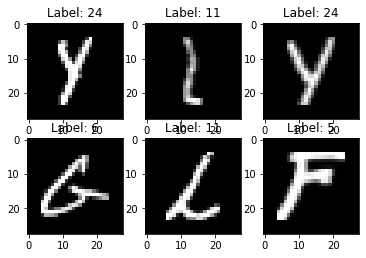

In [15]:
## Let's look at some example
plt.figure(figsize=[6,6])
for i in range(3,9):
    plt.subplot(3,3,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [16]:
# Hyper-parameters
lr = 0.1
arch = [100]
mini_batch_size = 100
r = 26

In [42]:
network = []
prev = train_x.shape[1]
for i in range(len(arch)):
    network.append(Dense(prev, arch[i]))
    network.append(Sigmoid())
    prev = arch[i]
network.append(Dense(100, r))

In [43]:
from IPython.display import clear_output
train_log = []
val_log = []
test_log = []

Epoch 794
Train accuracy: 0.9986
Val accuracy: 0.8216666666666667
Test accuracy:  0.7927692307692308


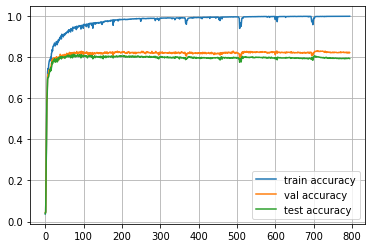

 86%|████████▌ | 86/100 [00:01<00:00, 69.01it/s]


KeyboardInterrupt: 

In [45]:
hyperparams = {'arch': [100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100, 'loss': 'mse', 'learning_rate':'constant', 'activation':'sigmoid'}
epoch = 0
while(True):
    if(epoch>11 and (test_log[-1]-test_log[-2]) < 0.0001 and (np.average(test_log[-10:])-test_log[-11])<0.0001):
#     if(epoch>900):
        break
    cnt=1
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=hyperparams['mini_batch_size'],shuffle=True):
        train(network,x_batch,y_batch,itr=cnt,learning_rate=hyperparams['learning_rate'],loss=hyperparams['loss'])
        cnt+=1
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    test_log.append(np.mean(predict(network, X_test)==y_test))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    print("Test accuracy: ", test_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    epoch += 1
print(test_log)

In [32]:
test_log

[0.05815384615384615,
 0.3326153846153846,
 0.528,
 0.561076923076923,
 0.577076923076923,
 0.6770769230769231,
 0.7024615384615385,
 0.6806153846153846,
 0.7386153846153846,
 0.7307692307692307,
 0.7367692307692307,
 0.7641538461538462,
 0.7595384615384615,
 0.7756923076923077,
 0.7743076923076923,
 0.7672307692307693,
 0.7864615384615384,
 0.7892307692307692,
 0.7858461538461539,
 0.7993846153846154,
 0.7815384615384615,
 0.7950769230769231,
 0.7866153846153846,
 0.8066153846153846,
 0.808923076923077,
 0.8018461538461539,
 0.8086153846153846,
 0.8044615384615385,
 0.7996923076923077,
 0.8112307692307692,
 0.7972307692307692,
 0.7987692307692308,
 0.8001538461538461,
 0.8147692307692308,
 0.805076923076923,
 0.7941538461538461,
 0.8041538461538461,
 0.807076923076923,
 0.803076923076923,
 0.8052307692307692,
 0.812,
 0.8084615384615385,
 0.8066153846153846,
 0.8075384615384615,
 0.8133846153846154,
 0.811076923076923,
 0.804923076923077,
 0.811076923076923,
 0.808,
 0.808,
 0.8135384

<h4>nnet params:</h4>
Epoch 100<br>
Loss='mse' | Activation='Sigmoid' | Architecture=[100] | lr=0.1<br>
<h4>Result of part-a</h4>
Train accuracy: 0.9941<br>
Val accuracy: 0.912<br>
Test accuracy:  0.9070769230769231<br>

><h3>Part b - Varying single hidden layer size</h3>

In [48]:
def run_nnet(hyperparams, output_dest):
    network = []
    prev = train_x.shape[1]
    for i in range(len(hyperparams['arch'])):
        network.append(Dense(prev, hyperparams['arch'][i]))
        if(hyperparams['activation']=='sigmoid'):
          network.append(Sigmoid())
        elif(hyperparams['activation']=='relu'):
          network.append(ReLU())
        else:
          print('Wrong activation biatch..')
          exit(1)
        prev = hyperparams['arch'][i]
    network.append(Dense(prev, hyperparams['r']))
    
    train_log = []
    val_log = []
    test_log = []
    
    epoch = 0
    while(True):
    # for epoch in range(20):
        if(epoch>11 and (val_log[-1]-val_log[-2]) < 0.0001 and (np.average(val_log[-10:])-val_log[-11])<0.0001):
          break
        cnt=1
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=hyperparams['mini_batch_size'],shuffle=True):
            train(network,x_batch,y_batch,itr=cnt,learning_rate=hyperparams['learning_rate'],loss=hyperparams['loss'])
            cnt+=1
        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))
        test_log.append(np.mean(predict(network, X_test)==y_test))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        print("Test accuracy: ", test_log[-1])
        epoch += 1
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('./results/'+output_dest+'/'+str(hyperparams['arch'])+'_layer_size.png')
    plt.clf()
    
    return train_log[-1], test_log[-1]

In [49]:
hyperparams = {'arch': [100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100, 'loss': 'mse', 'learning_rate':'constant', 'activation':'sigmoid'}
archlist = [1, 5, 10, 50, 100]
yy_train = []
yy_test = []
time_l = []
for i in (archlist):
    hyperparams['arch'] = [i]
    start = time.time()
    train_acc, test_acc = run_nnet(hyperparams, output_dest='b')
    yy_train.append(train_acc)
    yy_test.append(test_acc)
    time_l.append(time.time()-start)

plt.plot(archlist, yy_train, label = 'training acc')
plt.plot(archlist, yy_test, label = 'testing acc')
plt.legend(loc='best')
plt.grid()
plt.savefig('./results/b/'+'acc_vs_layer_size'+'.png')
plt.clf()

Epoch 36
Train accuracy: 0.822
Val accuracy: 0.7496666666666667
Test accuracy:  0.7487692307692307


<Figure size 432x288 with 0 Axes>

In [0]:
print('Layer size vs exec. time:')
for i in range(len(archlist)):
    print('%d|%s|%s|%s|' % (archlist[i], str(time_l[i]), yy_train[i], yy_test[i]))

<center><h3>Layer size vs exec. time [100 epochs with Sigmoid]:</h3></center>
<center><b>Model Details:</b> Arch: [100], r: 26, lr: 0.1, mini_batch_size: 100, Loss: 'mse','learning_rate':'constant</center>

|Layer Size|Exec Time (sec)|Train Accuracy|Test Accuracy|
|----------|---------|--------------|-------------|
1|48.07287645339966|0.1068|0.10538461538461538|
5|55.723833322525024|0.6203|0.5678461538461539|
10|56.60548114776611|0.8197|0.7309230769230769|
50|79.56502532958984|0.978|0.8803076923076923|
100|112.03223538398743|0.9926|0.9018461538461539|

<h3>Part C - Adaptive Learning</h3>


In [50]:
hyperparams = {'arch': [100], 'r': 26, 'lr': 1, 'mini_batch_size': 100, 'loss': 'mse', 'learning_rate':'adaptive', 'activation':'sigmoid'}

network = []
prev = train_x.shape[1]
for i in range(len(hyperparams['arch'])):
    network.append(Dense(prev, hyperparams['arch'][i]))
    if(hyperparams['activation']=='sigmoid'):
      network.append(Sigmoid())
    elif(hyperparams['activation']=='relu'):
      network.append(ReLU())
    else:
      print('Wrong activation biatch..')
      exit(1)
    prev = hyperparams['arch'][i]
network.append(Dense(prev, hyperparams['r']))

train_log = []
val_log = []
test_log = []

Epoch 99
Train accuracy: 0.9291
Val accuracy: 0.851
Test accuracy:  0.8403076923076923


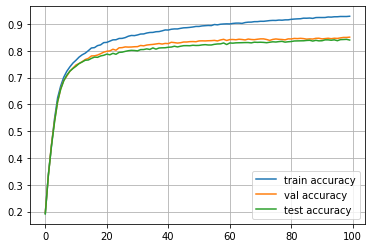

In [51]:
for epoch in range(100):
    cnt=1
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=hyperparams['mini_batch_size'],shuffle=True):
        train(network,x_batch,y_batch,itr=math.sqrt(cnt),learning_rate=hyperparams['learning_rate'],loss=hyperparams['loss'])
        cnt+=1
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    test_log.append(np.mean(predict(network, X_test)==y_test))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    print("Test accuracy: ", test_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [32]:
a = np.array([1,2,3,4])
print((a - np.average(a)) / np.linalg.norm(a))

[-0.27386128 -0.09128709  0.09128709  0.27386128]


<h4>Report:</h4>

Here we could increase the number of epochs since the error is being minimized by using adaptive learning.<br>
250 epochs used for every size of layer. Although, smaller size architectures require less epochs.
The convergence condition will take care of that.

<h3>For variable numbers of hidden layer units:</h3>

In [17]:
hyperparams = {'arch': [100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100, 'loss': 'mse', 'learning_rate':'adaptive', 'activation':'sigmoid'}
archlist = [1, 5, 10, 50, 100]
yy_train = []
yy_test = []
time_l = []
for i in (archlist):
    hyperparams['arch'] = [i]
    start = time.time()
    train_acc, test_acc = run_nnet(hyperparams, output_dest='c')
    yy_train.append(train_acc)
    yy_test.append(test_acc)
    time_l.append(time.time()-start)

plt.plot(archlist, yy_train, label = 'training acc')
plt.plot(archlist, yy_test, label = 'testing acc')
plt.legend(loc='best')
plt.grid()
plt.savefig('./results/c/'+'acc_vs_layer_size'+'.png')
plt.clf()

Epoch 249
Train accuracy: 0.849
Val accuracy: 0.8413333333333334
Test accuracy:  0.820923076923077


<Figure size 432x288 with 0 Axes>

In [28]:
print('Layer size vs exec. time:')
for i in range(len(archlist)):
    print('%d|%s|%s|%s|' % (archlist[i], str(time_l[i]), yy_train[i], yy_test[i]))

Layer size vs exec. time:
1|121.19889783859253|0.0825|0.084|
5|136.91906642913818|0.4938|0.48830769230769233|
10|142.9232461452484|0.7101|0.6796923076923077|
50|200.8067603111267|0.8441|0.806923076923077|
100|283.5222330093384|0.849|0.820923076923077|


<center><h3>Layer size vs exec. time [250 epochs with Sigmoid]:</h3></center>
<center><b>Model Details:</b> Arch: [100] | r: 26 | lr: 1 | mini_batch_size: 100 | Loss: 'mse'| Learning_rate:'adaptive'</center>

|Layer Size|Exec Time (sec)|Train Accuracy|Test Accuracy|
|----------|---------|--------------|-------------|
1|121.19889783859253|0.0825|0.084|
5|136.91906642913818|0.4938|0.48830769230769233|
10|142.9232461452484|0.7101|0.6796923076923077|
50|200.8067603111267|0.8441|0.806923076923077|
100|283.5222330093384|0.849|0.820923076923077|

Report: 
Exec time is larger than the previous parts since we are running 10 times more number of epochs.
But the average exec time per epoch in part-c and part-b is nearly same, even with the major difference being adaptive learning rate in part-c.

<h3>Part d - Introduction of 2 hidden layers and ReLU</h3>

In [0]:
hyperparams = {'arch': [100, 100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100, 'loss': 'mse', 'learning_rate':'adaptive', 'activation':'relu'}

network = []
prev = train_x.shape[1]
for i in range(len(hyperparams['arch'])):
    network.append(Dense(prev, hyperparams['arch'][i]))
    if(hyperparams['activation']=='sigmoid'):
      network.append(Sigmoid())
    elif(hyperparams['activation']=='relu'):
      network.append(ReLU())
    else:
      print('Wrong activation biatch..')
      exit(1)
    prev = hyperparams['arch'][i]
network.append(Dense(prev, hyperparams['r']))

train_log = []
val_log = []
test_log = []

Epoch 106
Train accuracy: 0.9965
Val accuracy: 0.92
Test accuracy:  0.9144615384615384


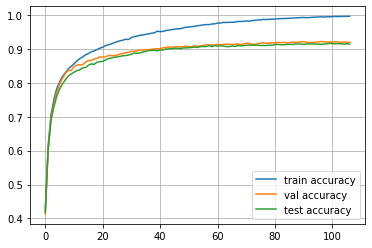

In [44]:
epoch = 0
while(True):
# for epoch in range(20):
    if(epoch>6 and abs(np.average(train_log[-5:])-train_log[-6])<0.0001):
      break
    cnt=1
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=hyperparams['mini_batch_size'],shuffle=True):
        train(network,x_batch,y_batch,itr=math.sqrt(cnt),learning_rate=hyperparams['learning_rate'],loss=hyperparams['loss'])
        cnt+=1
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    test_log.append(np.mean(predict(network, X_test)==y_test))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    print("Test accuracy: ", test_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    epoch += 1

<h4>Model:</h4>

>hyperparams = {'arch': [100, 100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100, 'loss': 'mse', 'learning_rate':'adaptive', 'activation':'relu'}


Epochs 106
1. Train accuracy: 0.9965
2. Val accuracy: 0.92
3. Test accuracy:  0.9144615384615384

<h3>Part e - sklearn.MLPClassifier</h3>

In [60]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu', solver='sgd', learning_rate='adaptive', batch_size=100)

In [61]:
history = clf.fit(train_x, train_y)

/home/karan/.local/lib/python3.6/site-packages/scikit_learn-0.22.2.post1-py3.6-linux-x86_64.egg/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


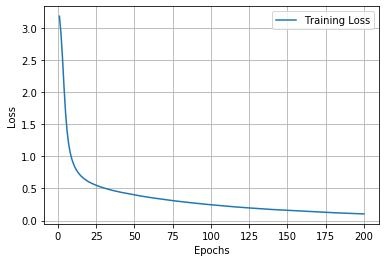

In [63]:
loss_values = history.loss_curve_
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [59]:
print('Train Accuracy: ', clf.score(train_x, train_y))
print('Test Accuracy: ', clf.score(test_x, test_y))

Train Accuracy:  0.9874615384615385
Test Accuracy:  0.9041538461538462


<h3>Part F - Self Implementation till part d + cross-entropy loss</h3>

In [58]:
hyperparams = {'arch': [100, 100], 'r': 26, 'lr': 0.1, 'mini_batch_size': 100, 'loss': 'crossentropy', 'learning_rate':'adaptive', 'activation':'relu'}

network = []
prev = train_x.shape[1]
for i in range(len(hyperparams['arch'])):
    network.append(Dense(prev, hyperparams['arch'][i]))
    if(hyperparams['activation']=='sigmoid'):
      network.append(Sigmoid())
    elif(hyperparams['activation']=='relu'):
      network.append(ReLU())
    else:
      print('Wrong activation biatch..')
      exit(1)
    prev = hyperparams['arch'][i]
network.append(Dense(prev, hyperparams['r']))

train_log = []
val_log = []
test_log = []

Epoch 19
Train accuracy: 0.9677
Val accuracy: 0.9063333333333333
Test accuracy:  0.8944615384615384


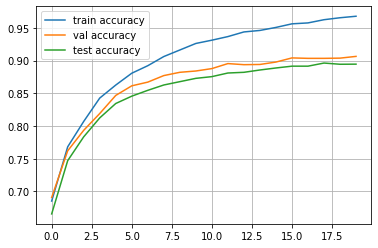

In [59]:
# epoch = 0
epoch_loss = []
# while(True):
for epoch in range(20):
#     if(epoch>6 and abs(np.average(train_log[-5:])-train_log[-6])<0.0001):
#       break
    cnt=1
    mini_batch_loss = []
    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=hyperparams['mini_batch_size'],shuffle=True):
        temp = train(network,x_batch,y_batch,itr=math.sqrt(cnt),learning_rate=hyperparams['learning_rate'],loss=hyperparams['loss'])
        mini_batch_loss.append(temp)
        cnt+=1
    
    mini_batch_loss = np.array(mini_batch_loss)
    epoch_loss.append(np.average(mini_batch_loss))

    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    test_log.append(np.mean(predict(network, X_test)==y_test))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    print("Test accuracy: ", test_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.plot(test_log, label='test accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
#     epoch += 1

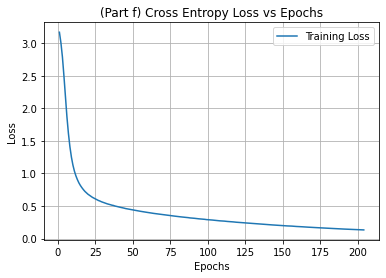

In [69]:
loss_values = epoch_loss
epochs = range(1, len(loss_values)+1)
plt.title('(Part f) Cross Entropy Loss vs Epochs')
plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()